In [1]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from dateutil.easter import easter
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

In [4]:
# open csv file and load the data into pandas dataframe
df_RawSalesData = pd.read_csv('../data/raw/train.csv', parse_dates=['date'], low_memory=False)
df_RawSalesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null datetime64[ns]
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [5]:
df_RawSalesData.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [6]:
df_RawSalesData.shape

(913000, 4)

In [7]:
df_RawSalesData.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [8]:
df_RawSalesData[df_RawSalesData.sales ==0]


date  store  item  sales
64289 2014-01-15      6     4      0

In [9]:
df_RawSalesData.head()

date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [10]:
df_RawSalesData.sample(5)

date  store  item  sales
746819 2017-12-17      9    41     19
441990 2013-04-09      3    25     71
451666 2014-10-07      8    25     74
659055 2017-08-23      1    37     28
327024 2013-06-20     10    18    105

In [11]:
df_RawSalesData.count(axis=0, numeric_only=False)

date     913000
store    913000
item     913000
sales    913000
dtype: int64

In [12]:
# Missing Values
#---------------
df_RawSalesData.isnull().any().value_counts() 

#All 4 columns have no missing values

False    4
dtype: int64

In [13]:
#Outliers
#--------
#Next we will figure out the outliers with The interquartile range (IQR), also called the midspread or middle 50%
#It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
#IQR is somewhat similar to Z-score in terms of finding the distribution of data and then keeping some threshold to identify the outlier.

Q1 = df_RawSalesData.quantile(0.25)
Q3 = df_RawSalesData.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


store     5.0
item     25.0
sales    40.0
dtype: float64


There appears to be some outliers in the sales column. Let's plot and check

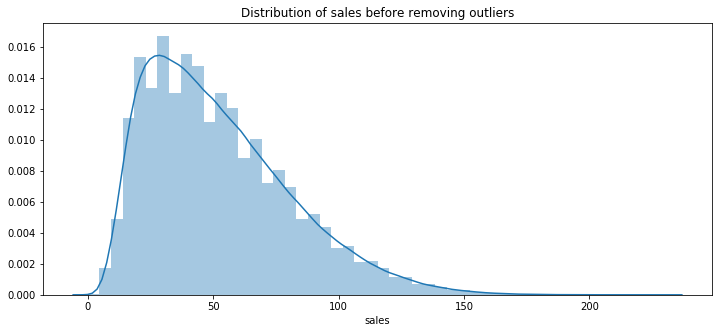

In [14]:
# target variable - sales and its distribution
plt.figure(figsize=(12,5))
plt.title("Distribution of sales before removing outliers")
ax = sns.distplot(df_RawSalesData['sales'])

In [15]:
#After computing the value of IQR, using threshhold of 1.5 * IQR away from Q1 and Q3 on both sides 
#df_RawData = df_RawSalesData
#df_RawData = df_RawData.drop('date', axis =1)
df_RawSalesDataReduced = df_RawSalesData[~((df_RawSalesData.sales < (Q1.sales - 1.5 * IQR.sales)) |(df_RawSalesData.sales > (Q3.sales + 1.5 * IQR.sales)))]



In [16]:
df_RawSalesDataReduced.shape

(901033, 4)

In [17]:
df_RawSalesDataReduced['sales'][df_RawSalesDataReduced.sales ==0]

64289    0
Name: sales, dtype: int64

In [18]:
#there is one day in the span of 5 years when sale of an item is 0, we will impute this as minimum sale 
df_RawSalesDataReduced.loc[df_RawSalesDataReduced.sales ==0, 'sales'] = 1

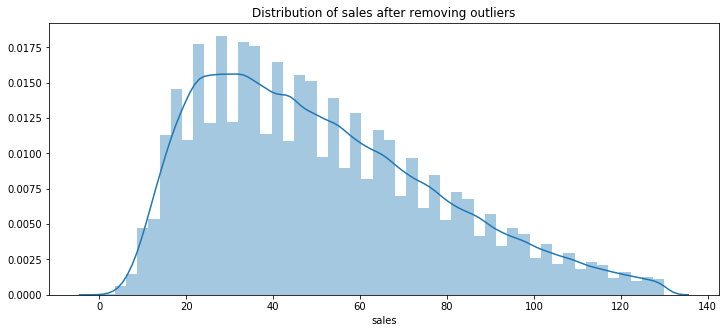

In [19]:
# target variable - sales and its distribution after removing the outliers
plt.figure(figsize=(12,5))
plt.title("Distribution of sales after removing outliers")
ax = sns.distplot(df_RawSalesDataReduced['sales'])

The plot still looks right skewed. Since sales is out target feature, 
we will be applying other transformations later on to remove the skew as much as possible before modeling.

In [20]:
df_RawSalesData.shape

(913000, 4)

In [21]:
df_SalesData = df_RawSalesDataReduced

In [22]:
#All the function definitions at one place 

def print_stats(col_name, group_by=False):
    """
    print the general statistics of the passed column
    """
    print('-'*60, '\n Individual Summary Statistics for', col_name, '\n', '-'*60)
    print('Describe \n',df_SalesData[col_name].describe(), '\n', '-'*20)
    print('Sample Observations \n',df_SalesData[col_name].sample(5), '\n', '-'*20)
    print('Number of Uniques \n',df_SalesData[col_name].nunique(), '\n', '-'*20)
    num_uniques = df_SalesData[col_name].nunique()
    if num_uniques <31: 
        print('Unique value counts \n', df_SalesData[col_name].value_counts(), '\n', '-'*20)
        
    if group_by:
        print('Group_by \n', df_SalesData.groupby('sales')[col_name].describe(), '\n','-'*20)
       
def store_analysis(store_num):
    df_store=df_SalesData.loc[df_SalesData['store'] == store_num]
    print(df_store.head())
    print('Top 5 selling items in store', store_num)
    print('-'*30, '\n')
    print(df_store[['sales','item']].groupby(['item']).mean().sort_values(by='sales',ascending=False).head())

    print('\n', 'Bottom 5 selling items in store', store_num )
    print('-'*30, '\n')
    print(df_store[['sales','item']].groupby(['item']).mean().sort_values(by='sales',ascending=False).tail())

    df_store[['sales','item']].groupby(["item"]).mean().sort_values(by='sales',ascending=False).plot.bar(width=0.2, title='store '+ str(store_num) +' item sales')
    plt.show()
    
def monthly_sales(store_num):
    
    for i in range(1, 10):
        df_store=df_SalesData.loc[df_SalesData['store'] == i]
        df_store[['sales','month']].groupby(["month"]).mean().sort_values(by='month',ascending=True).plot.bar(width=0.2, title='store '+ str(i) +' monthly sales')
        plt.show()
    
def plot_var(col_name, full_name, continuous):
    """
    plot a variable with and without sales.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name- for display purposes
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df_SalesData.loc[df_SalesData[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df_SalesData[col_name], order=sorted(df_SalesData[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of ' + full_name)

    # Plot with sales
    sns.catplot(x= col_name ,y='sales',data=df_SalesData,hue='store',kind='bar', ax=ax2)
    ax2.set_xlabel(full_name)
    ax2.set_ylabel('Sales')
    ax2.set_title(full_name + ' wise sales')
    plt.tight_layout()

def decomp_plot(df):
    decomposition = seasonal_decompose(df)
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(411)
    ax.plot(df, label='Original', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal,label='Seasonality', color = 'b')
    ax.legend(loc='best')
    ax= fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color = 'b')
    ax.legend(loc='best')
    plt.show()
    
def naive_forecast(df,coldate,colval,split):
    #print(split)
    import math
    global y_hat, train, test
    total_size=len(df)
    train_size=math.floor(split*total_size) #(split size)
    train=df.head(train_size)
    test=df.tail(len(df) -train_size)
    dd = np.asarray(train[colval])
    lastvalue = dd[len(dd)-1]
    y_hat = test.copy()
    y_hat['naive'] = lastvalue
    print(train.shape, test.shape, y_hat.shape)
    #return y_hat, train, test
    
    print(train.tail())
    print(test.head())
    plt.figure(figsize=(8,8))
    plt.plot(train.index, train[colval], label='Train')
    plt.plot(test.index, test[colval], label='Test')
    plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
    plt.ylabel = 'sales'
    plt.legend(loc='best')
    plt.title("Naive Forecast")
    plt.show()
    rms = sqrt(mean_squared_error(test[colval], y_hat.naive))
    mape = np.mean(np.abs((test[colval] - y_hat.naive) / test[colval])) * 100
    print('\n RMSE for Naive Forecast = '+str(rms))    
    print('\n MAPE for Naive Forecast = '+str(mape))    



In [23]:
df_SalesData.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [24]:
#let's plit the date for easier handling later

df_SalesData['day'] = df_SalesData.date.dt.day
df_SalesData['month'] = df_SalesData.date.dt.month
df_SalesData['year'] = df_SalesData.date.dt.year
df_SalesData['dayofweek'] = df_SalesData.date.dt.dayofweek

EDA
-----
#Next we will move on to EDA with individual features

Next, We will inspect each feature individually. We will perform the univariate and bivariate analysis using the folloiwng steps- Summary statistics Plot individually Plot against our target variable- sales. Modify the feature to make it ready for modelling, if necessary
For individual summary statistics we will use 
    .describe()
    .sample(5)
    .nunique()

Finally we will plot the feature against our target feature sales to see if and how both are related

1. Item
-------

In [25]:
print_stats('item')

------------------------------------------------------------ 
 Individual Summary Statistics for item 
 ------------------------------------------------------------
Describe 
 count    901033.000000
mean         25.526636
std          14.470524
min           1.000000
25%          13.000000
50%          26.000000
75%          38.000000
max          50.000000
Name: item, dtype: float64 
 --------------------
Sample Observations 
 330398    19
293741    17
289345    16
632330    35
797233    44
Name: item, dtype: int64 
 --------------------
Number of Uniques 
 50 
 --------------------


Looks like there are 50 items. And we already saw there are 10 stores, so that gives us 500 time series in total.

In [26]:
print(sorted(df_SalesData.item.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [27]:
#It looks like there are 50 items with values 1-50

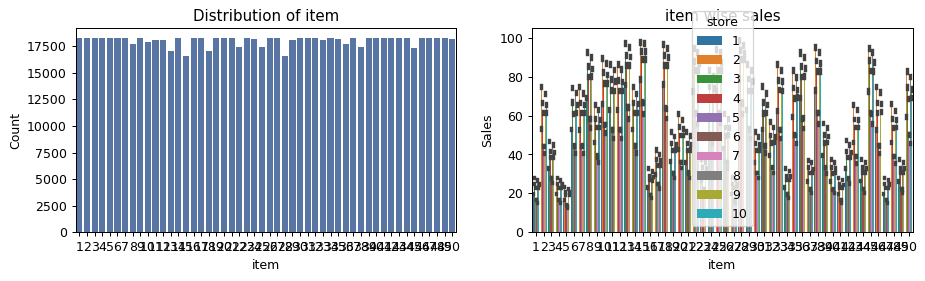

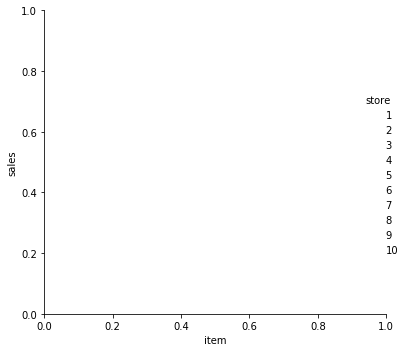

In [28]:
plot_var('item', 'item', False)

1. Store

In [29]:
print_stats('store')

------------------------------------------------------------ 
 Individual Summary Statistics for store 
 ------------------------------------------------------------
Describe 
 count    901033.000000
mean          5.503666
std           2.867474
min           1.000000
25%           3.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: store, dtype: float64 
 --------------------
Sample Observations 
 330274    1
671820    8
188955    4
892226    9
334744    4
Name: store, dtype: int64 
 --------------------
Number of Uniques 
 10 
 --------------------
Unique value counts 
 7     91300
5     91300
6     91298
1     91210
4     90576
9     90511
10    89841
3     89676
8     88234
2     87087
Name: store, dtype: int64 
 --------------------


Looks like there are 10 stores in our dataset. Each store has 91300 individual sales recorded in the dataset.
The column has no missing values and no special characters etc in the data values. The values are 1-10. 
So we will not need to do any pre-processing. 
Let's move onto plotting the graphs!

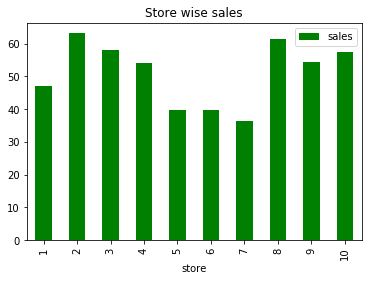

In [30]:
# Let's see the store wise sales
df_SalesData[['sales','store']].groupby(["store"]).mean().plot.bar(color='g', title='Store wise sales')
plt.show()

From the above we see that
1. Store 2 and 8 have highest sales
2. Store 5 and 7 have lowest sales

Store wise item sales Analysis
-----------------------------------


        date  store  item  sales  day  month  year  dayofweek
0 2013-01-01      1     1     13    1      1  2013          1
1 2013-01-02      1     1     11    2      1  2013          2
2 2013-01-03      1     1     14    3      1  2013          3
3 2013-01-04      1     1     13    4      1  2013          4
4 2013-01-05      1     1     10    5      1  2013          5
Top 5 selling items in store 1
------------------------------ 

          sales
item           
28    78.880332
15    78.812118
18    76.077558
13    75.936229
38    73.123077

 Bottom 5 selling items in store 1
------------------------------ 

          sales
item           
41    20.002738
1     19.971522
4     19.956188
47    19.814348
5     16.612815


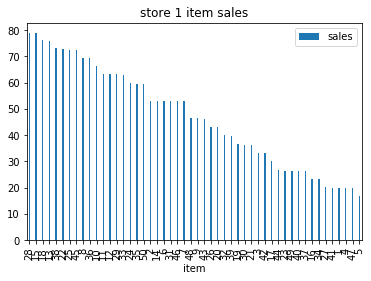

In [31]:
#Store 1:
store_analysis(1)

           date  store  item  sales  day  month  year  dayofweek
1826 2013-01-01      2     1     12    1      1  2013          1
1827 2013-01-02      2     1     16    2      1  2013          2
1828 2013-01-03      2     1     16    3      1  2013          3
1829 2013-01-04      2     1     20    4      1  2013          4
1830 2013-01-05      2     1     16    5      1  2013          5
Top 5 selling items in store 2
------------------------------ 

          sales
item           
28    98.746269
15    97.774865
13    97.028452
18    96.724648
38    95.195567

 Bottom 5 selling items in store 2
------------------------------ 

          sales
item           
4     28.234940
47    28.187842
1     28.173604
41    28.069551
5     23.540526


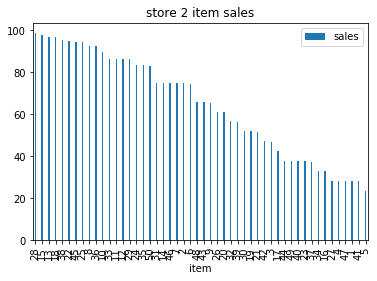

In [32]:
#Store 2:
store_analysis(2)


           date  store  item  sales  day  month  year  dayofweek
3652 2013-01-01      3     1     19    1      1  2013          1
3653 2013-01-02      3     1      8    2      1  2013          2
3654 2013-01-03      3     1     10    3      1  2013          3
3655 2013-01-04      3     1     15    4      1  2013          4
3656 2013-01-05      3     1     22    5      1  2013          5
Top 5 selling items in store 3
------------------------------ 

          sales
item           
28    93.706399
15    93.117197
13    91.072209
18    90.974437
25    88.569679

 Bottom 5 selling items in store 3
------------------------------ 

          sales
item           
4     25.116101
27    25.090909
1     25.070099
41    24.989047
5     20.857612


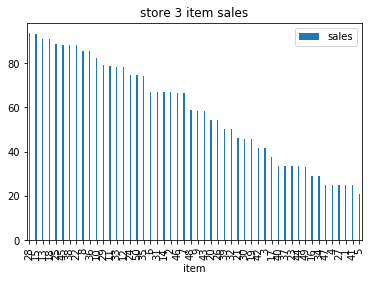

In [33]:
#Store 3:
store_analysis(3)


Interesting pattern emerging so far is the most and least sold items are more or less same for these all stores.
Let's see if the pattern continues for the restr of the stores

           date  store  item  sales  day  month  year  dayofweek
5478 2013-01-01      4     1     10    1      1  2013          1
5479 2013-01-02      4     1     12    2      1  2013          2
5480 2013-01-03      4     1      8    3      1  2013          3
5481 2013-01-04      4     1     15    4      1  2013          4
5482 2013-01-05      4     1     19    5      1  2013          5
Top 5 selling items in store 4
------------------------------ 

          sales
item           
28    88.931419
15    88.907429
13    86.022414
18    85.933333
25    83.479167

 Bottom 5 selling items in store 4
------------------------------ 

          sales
item           
47    23.114458
27    23.111720
4     23.086528
1     22.938664
5     19.525192


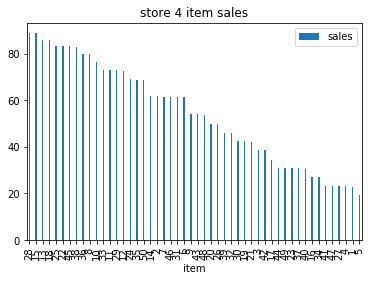

In [34]:
#Store 4:
store_analysis(4)

           date  store  item  sales  day  month  year  dayofweek
7304 2013-01-01      5     1     11    1      1  2013          1
7305 2013-01-02      5     1      9    2      1  2013          2
7306 2013-01-03      5     1     12    3      1  2013          3
7307 2013-01-04      5     1      8    4      1  2013          4
7308 2013-01-05      5     1     13    5      1  2013          5
Top 5 selling items in store 5
------------------------------ 

          sales
item           
15    66.987404
28    66.980832
13    64.395947
18    64.080504
45    61.427163

 Bottom 5 selling items in store 5
------------------------------ 

          sales
item           
4     16.776561
27    16.763417
1     16.739321
47    16.699343
5     14.086528


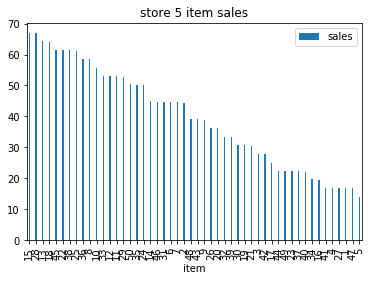

In [35]:
#Store 5:
store_analysis(5)

           date  store  item  sales  day  month  year  dayofweek
9130 2013-01-01      6     1     20    1      1  2013          1
9131 2013-01-02      6     1      6    2      1  2013          2
9132 2013-01-03      6     1     11    3      1  2013          3
9133 2013-01-04      6     1      7    4      1  2013          4
9134 2013-01-05      6     1     12    5      1  2013          5
Top 5 selling items in store 6
------------------------------ 

          sales
item           
15    66.668675
28    66.423562
13    64.324754
18    63.725630
25    61.326027

 Bottom 5 selling items in store 6
------------------------------ 

          sales
item           
4     16.754655
1     16.717963
47    16.708653
41    16.607338
5     13.893209


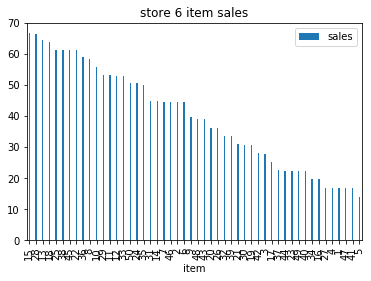

In [36]:
#Store 6:
store_analysis(6)

            date  store  item  sales  day  month  year  dayofweek
10956 2013-01-01      7     1      7    1      1  2013          1
10957 2013-01-02      7     1      4    2      1  2013          2
10958 2013-01-03      7     1      8    3      1  2013          3
10959 2013-01-04      7     1      7    4      1  2013          4
10960 2013-01-05      7     1      8    5      1  2013          5
Top 5 selling items in store 7
------------------------------ 

          sales
item           
15    61.139102
28    61.104053
18    58.745893
13    58.547645
25    56.398686

 Bottom 5 selling items in store 7
------------------------------ 

          sales
item           
41    15.471522
4     15.358160
27    15.213582
1     15.159365
5     12.733844


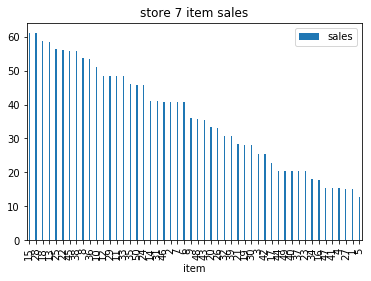

In [37]:
#Store 7:
store_analysis(7)

            date  store  item  sales  day  month  year  dayofweek
12782 2013-01-01      8     1     16    1      1  2013          1
12783 2013-01-02      8     1     10    2      1  2013          2
12784 2013-01-03      8     1     12    3      1  2013          3
12785 2013-01-04      8     1     21    4      1  2013          4
12786 2013-01-05      8     1     15    5      1  2013          5
Top 5 selling items in store 8
------------------------------ 

          sales
item           
15    97.420833
28    96.378359
13    95.327201
18    94.825017
22    92.851577

 Bottom 5 selling items in store 8
------------------------------ 

          sales
item           
27    27.044359
41    27.036145
1     26.983571
4     26.948521
5     22.427711


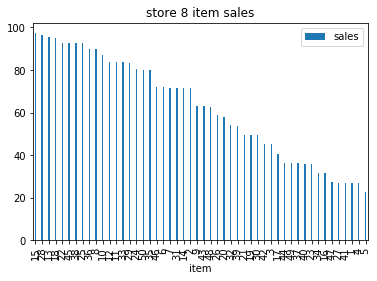

In [38]:
#Store 8:
store_analysis(8)

            date  store  item  sales  day  month  year  dayofweek
14608 2013-01-01      9     1     11    1      1  2013          1
14609 2013-01-02      9     1      9    2      1  2013          2
14610 2013-01-03      9     1     20    3      1  2013          3
14611 2013-01-04      9     1     22    4      1  2013          4
14612 2013-01-05      9     1     22    5      1  2013          5
Top 5 selling items in store 9
------------------------------ 

          sales
item           
28    88.865328
15    88.825283
13    85.957447
18    85.807958
25    83.472348

 Bottom 5 selling items in store 9
------------------------------ 

          sales
item           
1     23.325849
41    23.191128
4     23.150055
47    23.003286
5     19.272180


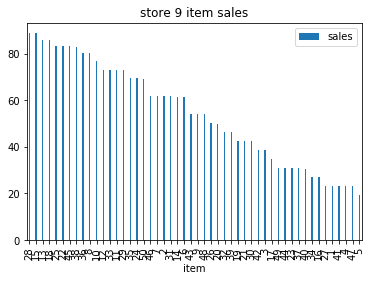

In [39]:
#Store 9:
store_analysis(9)

            date  store  item  sales  day  month  year  dayofweek
16434 2013-01-01     10     1     14    1      1  2013          1
16435 2013-01-02     10     1     14    2      1  2013          2
16436 2013-01-03     10     1     16    3      1  2013          3
16437 2013-01-04     10     1     17    4      1  2013          4
16438 2013-01-05     10     1     12    5      1  2013          5
Top 5 selling items in store 10
------------------------------ 

          sales
item           
15    93.139061
28    92.118719
13    90.367919
18    90.232014
25    87.485217

 Bottom 5 selling items in store 10
------------------------------ 

          sales
item           
1     24.736035
4     24.721249
27    24.701533
41    24.654984
5     20.637459


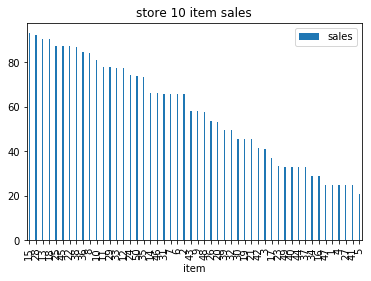

In [40]:
#Store 10:
store_analysis(10)

3. Date

In [41]:
df_SalesData.columns

Index(['date', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [42]:
print_stats('date')

------------------------------------------------------------ 
 Individual Summary Statistics for date 
 ------------------------------------------------------------
Describe 
 count                  901033
unique                   1826
top       2014-08-20 00:00:00
freq                      500
first     2013-01-01 00:00:00
last      2017-12-31 00:00:00
Name: date, dtype: object 
 --------------------
Sample Observations 
 162742   2013-08-17
611446   2017-04-12
750312   2017-07-11
813031   2014-04-07
358145   2013-09-07
Name: date, dtype: datetime64[ns] 
 --------------------
Number of Uniques 
 1826 
 --------------------


the dates are from Jan 1 2013 to Dec 31 2017
The dates are for 5 years period.

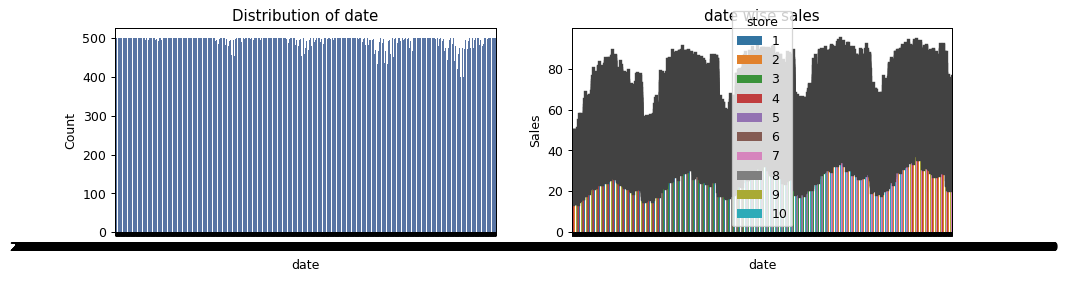

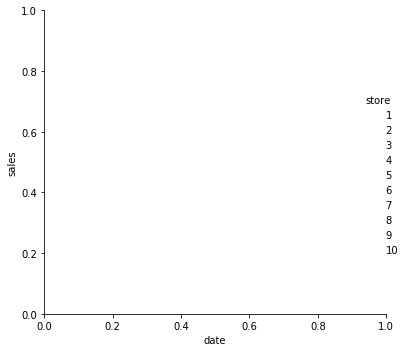

In [43]:
plot_var('date', 'date', False)

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



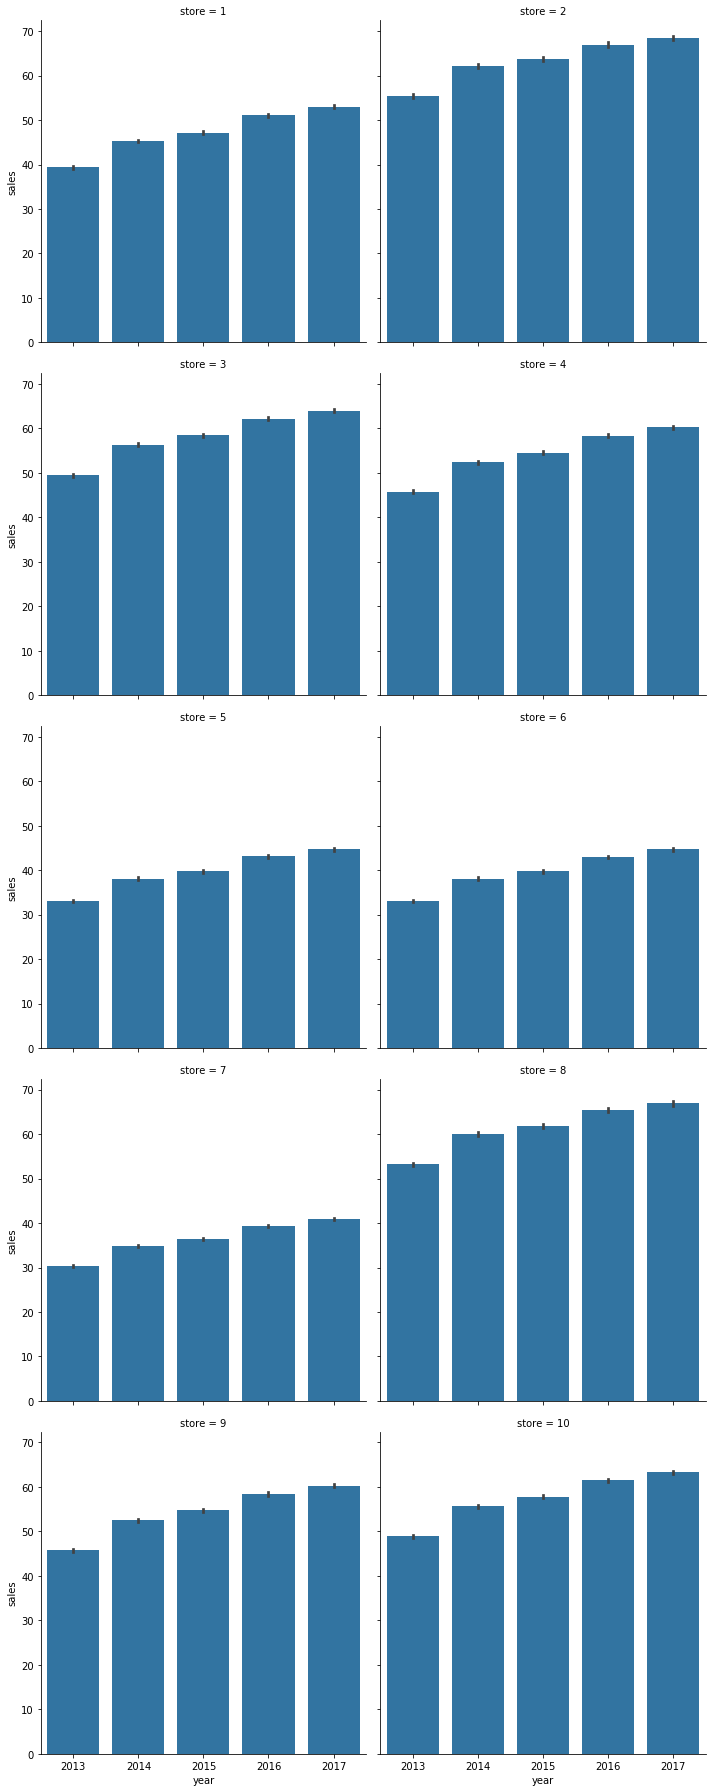

In [44]:
#let's plot the yearly sales for each store
g=sns.FacetGrid(df_SalesData,col="store", col_order=[1,2,3,4,5,6,7,8,9,10],col_wrap=2,height=5)
g.map(sns.barplot,"year","sales")

We see there is consistent increase in sales numbers every year at all the stores!


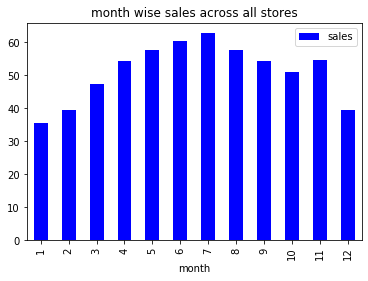

In [45]:
df_SalesData[['sales','month']].groupby(["month"]).mean().plot.bar(color='b', title='month wise sales across all stores')
plt.show()

Above plot shows there are higher sales in the month of June, July and August

#Sales
--------

In [46]:
print_stats('sales')

------------------------------------------------------------ 
 Individual Summary Statistics for sales 
 ------------------------------------------------------------
Describe 
 count    901033.000000
mean         51.032029
std          26.932924
min           1.000000
25%          29.000000
50%          46.000000
75%          68.000000
max         130.000000
Name: sales, dtype: float64 
 --------------------
Sample Observations 
 488233    32
321446    42
311037    71
404232    31
383552    51
Name: sales, dtype: int64 
 --------------------
Number of Uniques 
 130 
 --------------------


In [47]:
df_SalesData.columns

Index(['date', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek'], dtype='object')

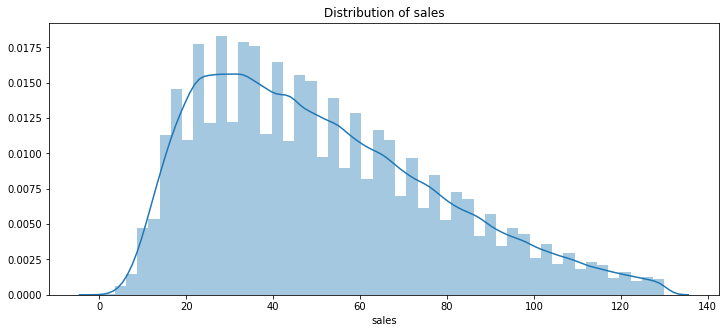

In [48]:
# let's check the distribution for sales feature using the dist plot
# target variable - sales and its distribution
plt.figure(figsize=(12,5))
plt.title("Distribution of sales")
ax = sns.distplot(df_SalesData['sales'])

In [49]:
# we have already removed the outliers before, and we still have the right skew in the distribution. 
#We will taking care of that later before the model building and tuning

In [50]:
df_SalesData.columns

Index(['date', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek'], dtype='object')

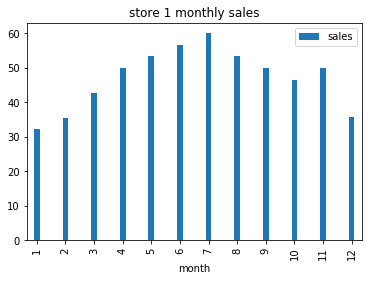

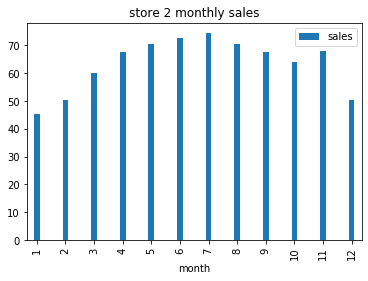

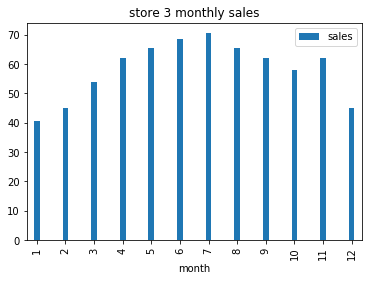

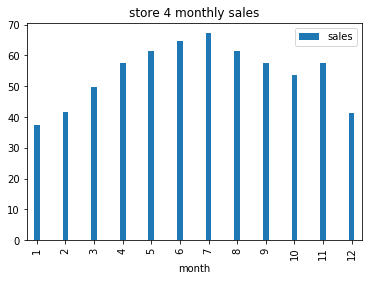

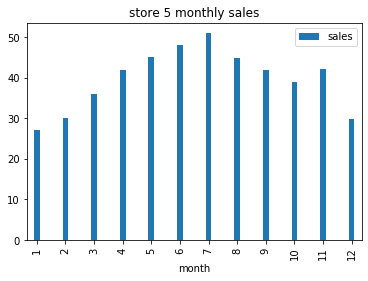

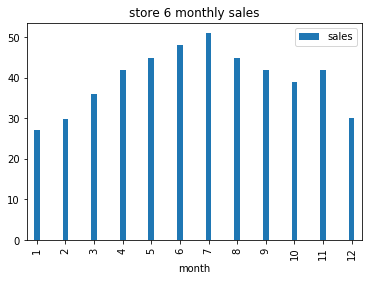

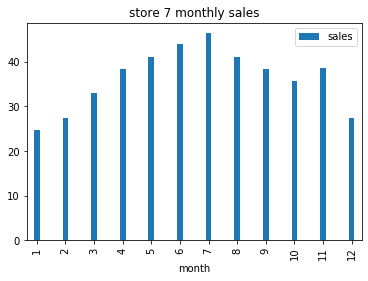

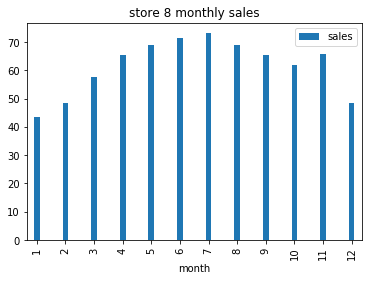

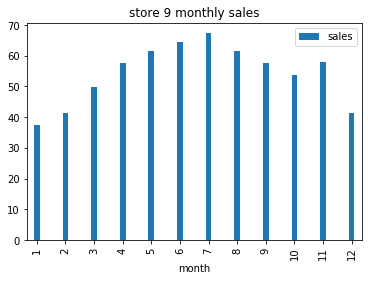

In [51]:
#let's plot monthly sales for each store, 
#that way we could comapre and see if the sales trends are similar across stores
monthly_sales(1)

Seasonality:
--------------
Let's plot the sales to look at the seasonality for-
-Yearly
-monthly
-weekly

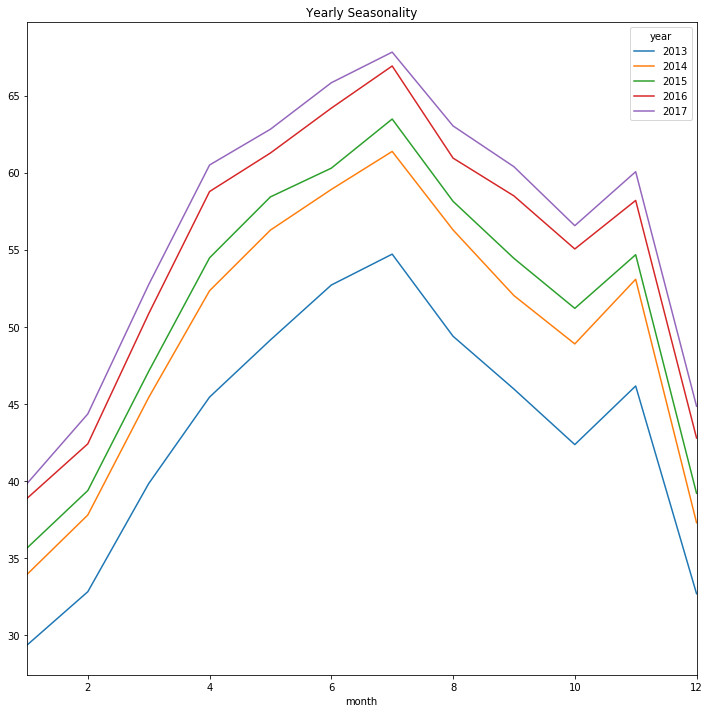

In [52]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='year', index='month')
pivoted.plot(figsize=(12,12), title='Yearly Seasonality');

From the above plot we can easily observe that-

-the sales go up year to year from 2013 to 2017 
- there is steady upward trend.
- there is also a monthly seasonality where sales are going up around middle of the year 

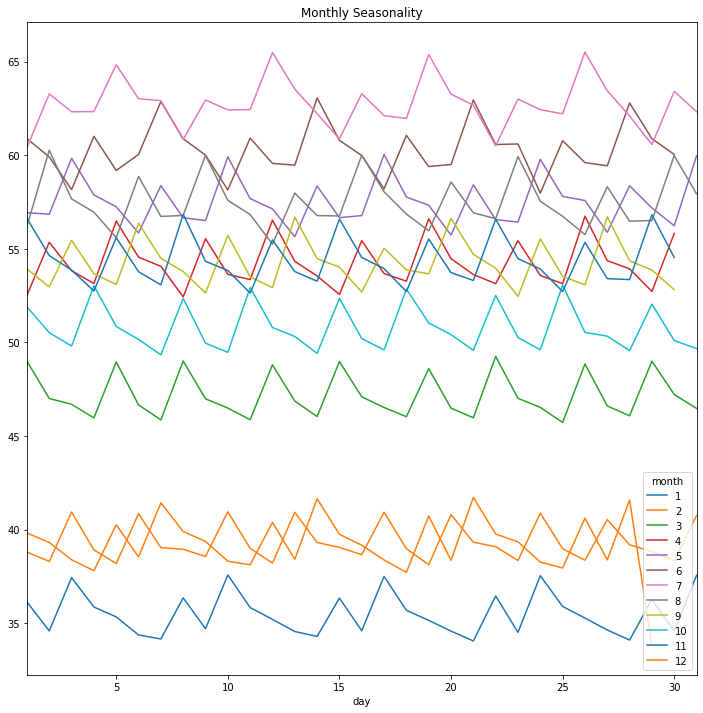

In [53]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='month', index='day')
pivoted.plot(figsize=(12,12), title='Monthly Seasonality');

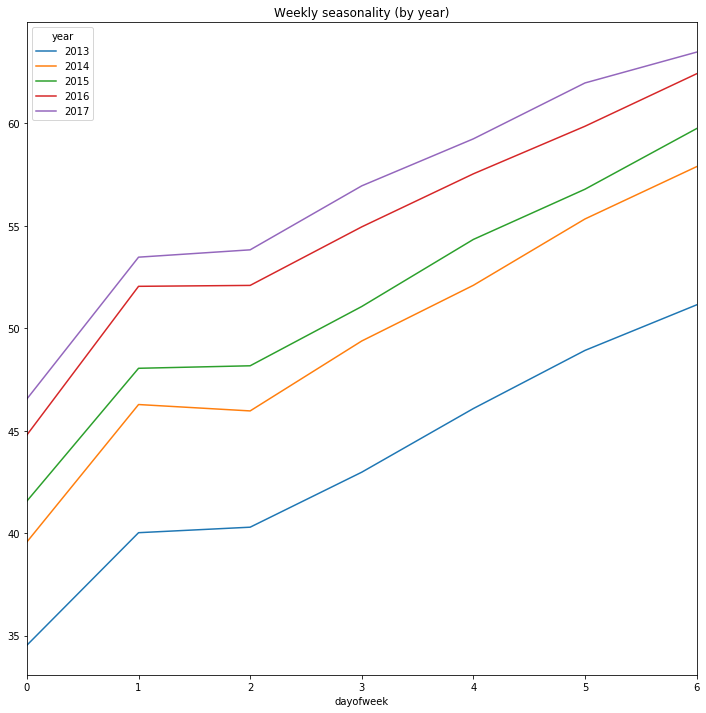

In [54]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='year', index='dayofweek')
pivoted.plot(figsize=(12,12), title='Weekly seasonality (by year)');

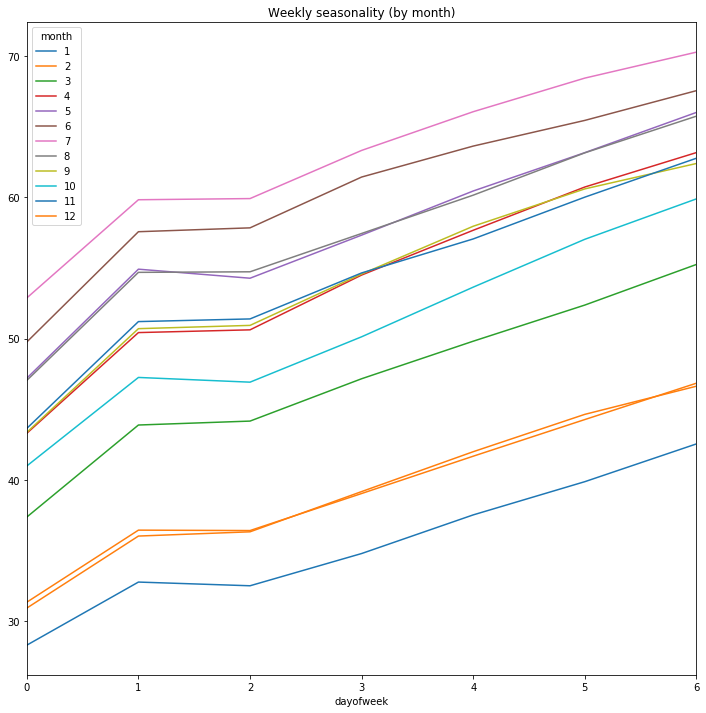

In [55]:
pivoted = pd.pivot_table(df_SalesData, values='sales', columns='month', index='dayofweek')
pivoted.plot(figsize=(12,12), title='Weekly seasonality (by month)');

This shows the sales follow the same trend year after year where sales peak up at the middle of the year and taper off with one exception in the month of November. Over the years the sales have gone up basically from year to year but follows the same trend.

In [56]:
df_SalesData.head()

date  store  item  sales  day  month  year  dayofweek
0 2013-01-01      1     1     13    1      1  2013          1
1 2013-01-02      1     1     11    2      1  2013          2
2 2013-01-03      1     1     14    3      1  2013          3
3 2013-01-04      1     1     13    4      1  2013          4
4 2013-01-05      1     1     10    5      1  2013          5

In [57]:
df_StoreSales=df_SalesData.loc[df_SalesData['store'] == 1]

In [58]:
df_StoreSales.index = df_StoreSales.date

ML Model
------------
The aim is to forecast the sales for items sold in the stores. We will have to forecast the sales for next 90 days.
We have been given the historical sales numbers for past 5 years for 50 items across 10 stores. The model will forecast the sales for these items across the stores for next 3 months.


Baseline Model - Naive Approach
---------------------------------------

Naive method assumes that the next expected point is equal to the last observed point. This approach uses the value of last day sales and uses it to estimate sales for next day. So we have y ^ @t+1 = y @t


(63846, 8) (27364, 8) (27364, 9)
                 date  store  item  sales  day  month  year  dayofweek
date                                                                  
2013-01-07 2013-01-07      1    36     27    7      1  2013          0
2013-01-08 2013-01-08      1    36     29    8      1  2013          1
2013-01-09 2013-01-09      1    36     39    9      1  2013          2
2013-01-10 2013-01-10      1    36     44   10      1  2013          3
2013-01-11 2013-01-11      1    36     39   11      1  2013          4
                 date  store  item  sales  day  month  year  dayofweek
date                                                                  
2013-01-12 2013-01-12      1    36     46   12      1  2013          5
2013-01-13 2013-01-13      1    36     51   13      1  2013          6
2013-01-14 2013-01-14      1    36     31   14      1  2013          0
2013-01-15 2013-01-15      1    36     47   15      1  2013          1
2013-01-16 2013-01-16      1    36     27   

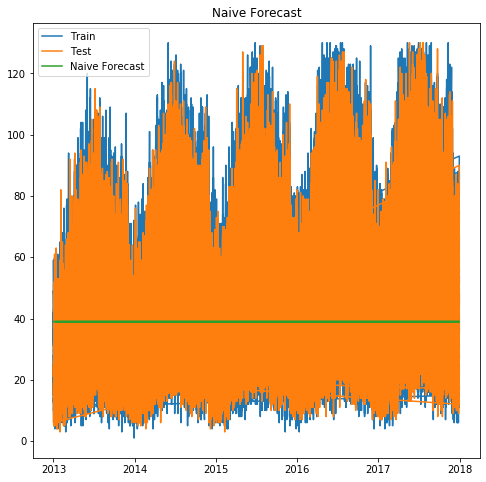


 RMSE for Naive Forecast = 22.89943168817892

 MAPE for Naive Forecast = 54.07746728841998


In [60]:
naive_forecast(df_StoreSales, 'date', 'sales', 0.7)

In [61]:
df_SalesData.columns

Index(['date', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [62]:
#df_SalesData.columns = ['ds', 'store', 'item', 'y', 'day', 'month', 'year', 'dayofweek', 'sqrt_sales']
df_SalesData.columns = ['ds', 'store', 'item', 'y', 'day', 'month', 'year', 'dayofweek']

In [63]:
df_SalesData.columns

Index(['ds', 'store', 'item', 'y', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [64]:
df_SalesData.shape

(901033, 8)

In [65]:
df_store=df_SalesData[df_SalesData['store'] == 2]
df_store = df_store[df_store['item'] == 15]
df_store.shape

(1297, 8)

In [66]:
df_store.describe()

store    item            y          day        month         year    dayofweek
count  1297.0  1297.0  1297.000000  1297.000000  1297.000000  1297.000000  1297.000000
mean      2.0    15.0    97.774865    15.786430     6.304549  2014.723978     2.487278
std       0.0     0.0    19.532702     8.736535     3.841246     1.398628     1.906786
min       2.0    15.0    44.000000     1.000000     1.000000  2013.000000     0.000000
25%       2.0    15.0    83.000000     8.000000     3.000000  2013.000000     1.000000
50%       2.0    15.0    99.000000    16.000000     6.000000  2015.000000     2.000000
75%       2.0    15.0   114.000000    23.000000    10.000000  2016.000000     4.000000
max       2.0    15.0   130.000000    31.000000    12.000000  2017.000000     6.000000

ML Models
=========
We will build the model using Facebook Prophet package. It allows specifying multiple seasonalities and special events and allows making predictions.

Approach
------------
Since there are 10 stores with 50 items each, we have 500 time series. For training our model we will take the representation of these data series and build our model. Then we will compare and eveluate the model performnaces. Once we have finalized the best model depending on the performance, we will continue on the best model to forecast our 90 day period for the rest of the stores. 
Representative data
-----------------------
We have Store 2 and 8 with highest sales and Store 5 and 7 with lowest sales. We will choose highest selling and lowest selling items from each of these stores
-SO we have -
Store 2- top 15 bottom 5 , top is 28 and second top is 15
Store 8- top 15 bottom 5
Store 5- top 15 bottom 5
Store 7- top 15 bottom 5
For the consistency purpose, and going with the majority we will be choosing item number 15 and 5 from each store.
Final Forecast
-----------------
Once we have evaluated and chosen the best model depening on the model performance, we will forecast all 500 series for the 90 day period


Prophet Baseline
--------------------

In [67]:
#Baseline Prophet
#Model Fitting
prModel = Prophet()
prModel.fit(df_store[['ds','y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
#predicting
future = prModel.make_future_dataframe(periods=90)
future.tail()

ds
1382 2018-03-27
1383 2018-03-28
1384 2018-03-29
1385 2018-03-30
1386 2018-03-31

In [69]:
forecast = prModel.predict(future)

In [70]:
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper       yhat
0 2013-01-01  88.793541   45.952438   69.917731    88.793541    88.793541      -30.956007            -30.956007            -30.956007  -5.575321     -5.575321     -5.575321 -25.380685    -25.380685    -25.380685                   0.0                         0.0                         0.0  57.837534
1 2013-01-02  88.819156   44.669583   70.232765    88.819156    88.819156      -31.290602            -31.290602            -31.290602  -5.801435     -5.801435     -5.801435 -25.489167    -25.489167    -25.489167                   0.0                         0.0                         0.0  57.528554
2 2013-01-03  88.844771   51.211634   75.707454    88.844771    88.844771      -25.278108            -25.278108            -25.278108   0.355633      0.355633      0.355633 -25.633741    -25.633741    -25.633741                   0.0                         0.0                         0.0  63.566663
3 2013-01-04  88.870386   55.865568   79.661910    88.870386    88.870386      -21.080666            -21.080666            -21.080666   4.727628      4.727628      4.727628 -25.808294    -25.808294    -25.808294                   0.0                         0.0                         0.0  67.789720
4 2013-01-05  88.896001   61.038114   85.426325    88.896001    88.896001      -15.645942            -15.645942            -15.645942  10.359823     10.359823     10.359823 -26.005764    -26.005764    -26.005764                   0.0                         0.0                         0.0  73.250060

In [71]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds        yhat  yhat_lower  yhat_upper
1382 2018-03-27  113.791988  101.757816  125.701359
1383 2018-03-28  113.970069  101.756783  125.867012
1384 2018-03-29  120.577330  108.702445  133.059631
1385 2018-03-30  125.444481  113.214576  138.216800
1386 2018-03-31  131.614322  118.755379  143.896063

In [72]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2013-01-01  57.837534   45.952438   69.917731
1 2013-01-02  57.528554   44.669583   70.232765
2 2013-01-03  63.566663   51.211634   75.707454
3 2013-01-04  67.789720   55.865568   79.661910
4 2013-01-05  73.250060   61.038114   85.426325

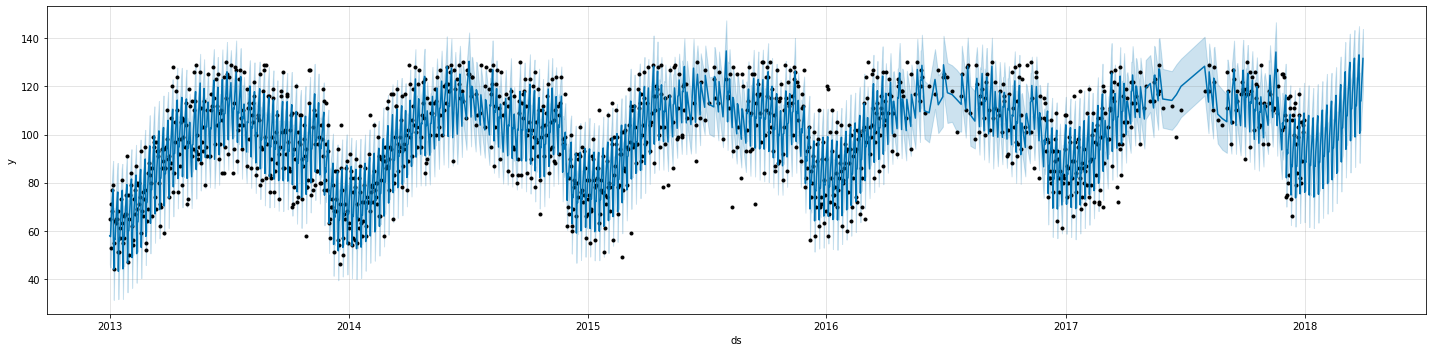

In [73]:
#The blue line in the graph represents the predicted values while the black dots represents the data in our dataset.
#and the light-blue shaded regions are the confidence intervals at 80%
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
fig = prModel.plot(forecast, ax=ax)
plt.show()

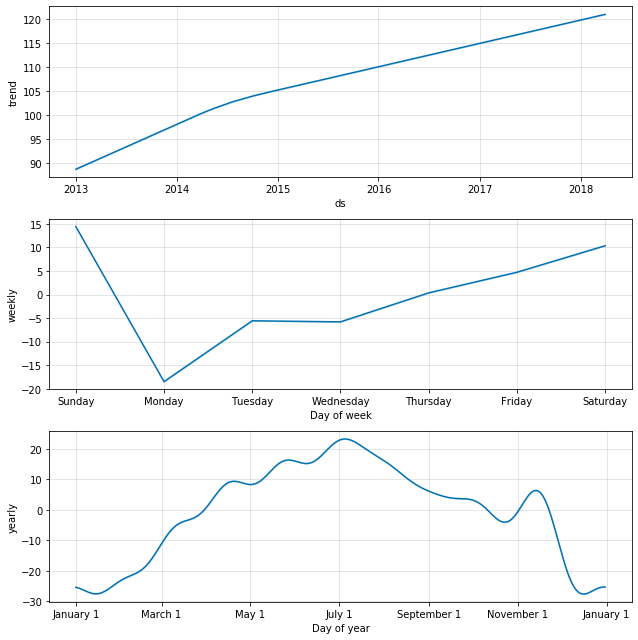

In [74]:
#Plot individual componenets of forecast
#The plot_components method plots the trend, yearly and weekly seasonality of the time series data.
plot2 = prModel.plot_components(forecast)

Results Analysis
-------------------
-Looking at the yearly plot, it looks like the shopping sales go higher in the month of July. And start tapering off till the end of the month with an exception of month of November. This might be due to the "black Friday' sales happening in Nov. So understandably the sales pick up in that month.
-Also if we look at the weekely plot, there is a peak in sales on Saturday and Sunday
-The first plot 'trend' shows consistent data as observed in our analysis that the sales have picked up year after year with a steady growth.


Cross Validation and Performance Metrics
-------------------------------------------------
SOme of the metrics for regression performance are - Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R Squared (R²),Adjusted R Squared (R²),Mean Squared Percentage Error (MSPE),Mean Absolute Percentage Error (MAPE)
While MSE deals with absolute errors, MPSE and MAPE work with relative errors.It can also be thought of as weighted versions of MAE. MAPE is considered to be popular measure of forecast accuracy.
We will start of by using RMSE and then move on to be using MAPE. 

1. horizon: the forecast horizon
2. initial: the size of the initial training period
3. period: the spacing between cutoff dates
The output of the cross_validation method is a dataframe containing y the true values and yhat the predicted values. We’ll use this dataframe to compute the prediction errors.

In [75]:
#Cross Validation with basic model
df_cv = cross_validation(prModel, initial = '720 days', period = '45 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00


ds       yhat  yhat_lower  yhat_upper    y     cutoff
0 2015-01-17  91.205047   80.456357  103.277380   86 2015-01-16
1 2015-01-18  96.593194   84.464854  107.831469  110 2015-01-16
2 2015-01-19  65.029294   52.548244   75.928220   63 2015-01-16
3 2015-01-20  76.869290   64.759232   88.803027   67 2015-01-16
4 2015-01-21  76.880184   64.714720   89.374715   77 2015-01-16

#
yhat : the predicted forecast
yhat_lower : the lower border of the prediction
yhat_upper: the upper border of the prediction
cutoff: how far into the future the prediction was

In [76]:
df_performance = performance_metrics(df_cv)
df_performance.head()

horizon         mse       rmse       mae      mape  coverage
0  9 days  105.593772  10.275883  7.926836  0.081609  0.756098
1 10 days  108.272608  10.405412  8.081824  0.084860  0.744715
2 11 days  107.610329  10.373540  8.076208  0.085645  0.749051
3 12 days  108.394648  10.411275  8.173086  0.086282  0.742339
4 13 days  107.120090  10.349884  8.119133  0.086121  0.737336

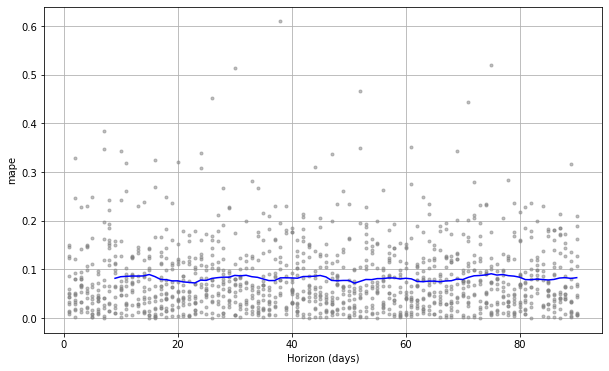

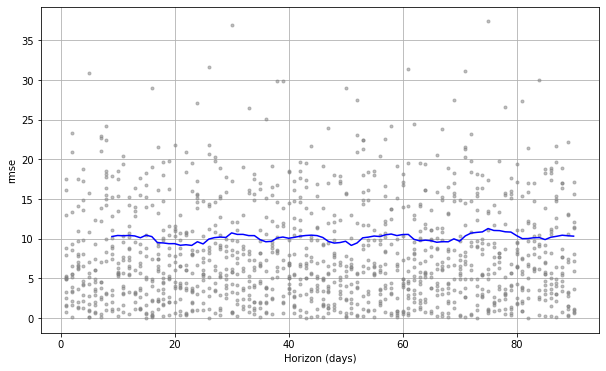

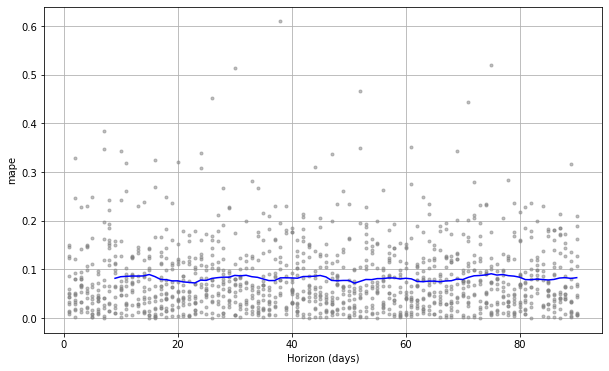

In [77]:
#Visualizing Performance Metrics
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric = 'rmse')
plot_cross_validation_metric(df_cv, metric = 'mape')

In [78]:
print('\n RMSE for Additive Prophet Model Forecast = '+str(np.mean(df_performance.rmse)))  
print('\n MAPE for Additive Prophet Model Forecast = '+str(np.mean(df_performance.mape) * 100) + '%')



 RMSE for Additive Prophet Model Forecast = 10.114566932833608

 MAPE for Additive Prophet Model Forecast = 8.133305871544037%


In [79]:
#df_SalesData.columns = ['ds', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek', 'sqrt_sales']
df_SalesData.columns = ['ds', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek']

In [80]:
df_SalesData.dtypes

ds           datetime64[ns]
store                 int64
item                  int64
sales                 int64
day                   int64
month                 int64
year                  int64
dayofweek             int64
dtype: object

Model Improvements
==================

We will do 2 things for model improvements
1. Transformations- We will try different transformations to see which one is best fit for out data distribution
2. Add Holidays and yearly special events to the model



1. Transformations - Data Skew
===============================
----------------------------------
As we had seen above in the EDA, the sales data distribution is a skewd distribution

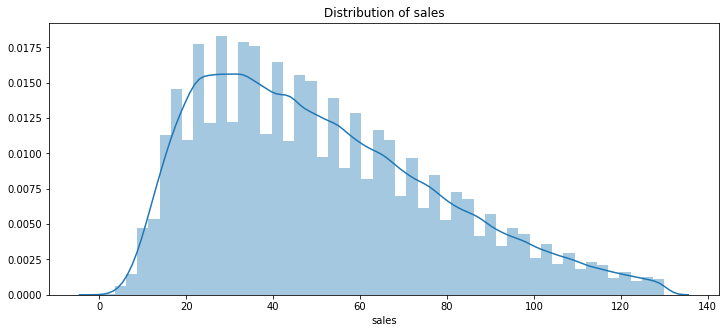

In [81]:
#Let's look at our target variable - sales and its distribution
plt.figure(figsize=(12,5))
plt.title("Distribution of sales")
ax = sns.distplot(df_SalesData['sales'])

a. Log Transform
================
#Let's log transform the sales features using np.log function 


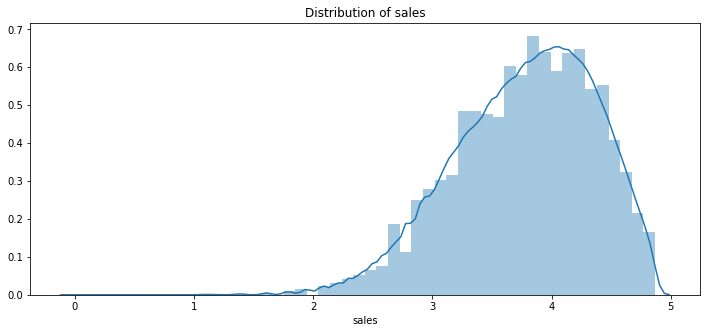

In [82]:
# log transform
#log_sales = np.log(df_SalesData.sales, where=(df_SalesData.sales!=0))
log_sales = np.log(df_SalesData.sales)
plt.figure(figsize=(12,5))
plt.title("Distribution of sales")
ax = sns.distplot(log_sales)


b. Square root transform
========================


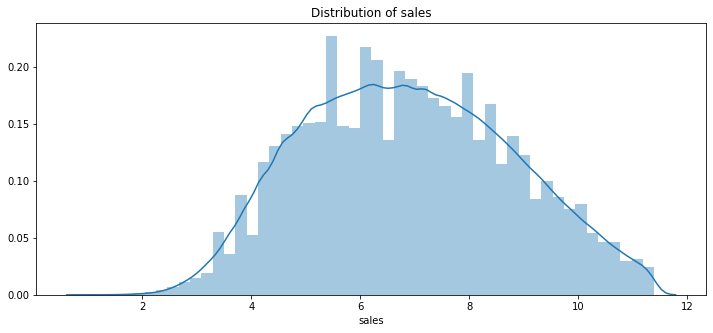

In [83]:

sqrt_sales = df_SalesData.sales ** (0.5)

plt.figure(figsize=(12,5))
plt.title("Distribution of sales")
ax = sns.distplot(sqrt_sales)




c. min max scaler transform
===========================

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64.



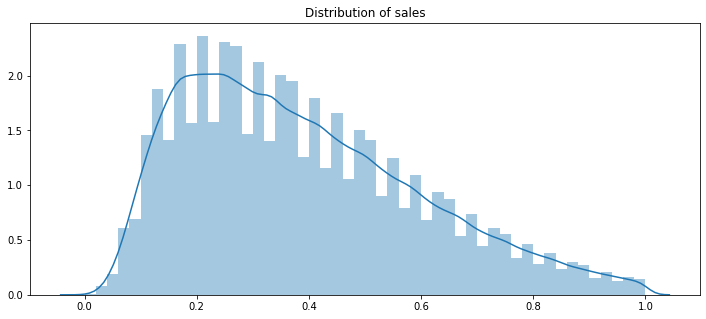

In [84]:
# mix-max scale the sales data between 0 and 1

from sklearn.preprocessing import minmax_scale

minmax_sales = minmax_scale(df_SalesData.sales)

plt.figure(figsize=(12,5))
plt.title("Distribution of sales")
ax = sns.distplot(minmax_sales)



In [85]:
#Of all three transforms, 
#square root transform works the best in removing the right skew for our dataset values as seen from the plots above.
#So of all, we will use the square root transformation for our data.
#Let's use that tranformation and train our data

df_SalesData['sqrt_sales']= sqrt_sales


2. Prophet Additive with Holidays:
===================================
------------------------------------
-For the reasons outlined above and looking the sales trend for 'Black Fridays' and over the weekends, we will see if adding holidays feature in prophet will improve the performance of the model or not.
We will now add seasonalities like yearly, monthly and daily. In addition we will also add the holidays to better improve the performance.

In [86]:
#Defining special events - superbowl and playoffs

playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))

In [87]:
def train_model(store_num, item_num):
    print('*'*40)
    print('Store: '+ str(store_num) + ' Item: ' + str(item_num) + ' Predictions')
    print('*'*40)    

    df_SalesData.columns = ['ds', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek', 'y']
    df_store=df_SalesData[(df_SalesData['item'] == item_num)]
    df_store=df_store[(df_store['store'] == store_num)]
    
    trainModel = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
    trainModel.add_country_holidays(country_name='US')
    trainModel.fit(df_store[['ds','y']])
    
    trainFuturedf = trainModel.make_future_dataframe(periods=90, freq='D')
    forecast_holi = trainModel.predict(trainFuturedf)
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(20)
    ax.set_title('sales predictions- black dot:data, dark blue: predictions, light blue:CI')
    fig = trainModel.plot(forecast_holi, ax=ax)
    plt.show()
    
    df_cv1 = cross_validation(trainModel , initial = '730 days', period = '45 days', horizon = '90 days')
    df_performance1 = performance_metrics(df_cv1)
    print('\n Performance Metric sample:')
    print('='*80)
    print(df_performance1.head())
    print('\n Sample Predictions:')
    print('='*80)
    print(df_cv1.head())
    
    print('-'*80)
    print('\n RMSE for Prophet Model-seasonalities + holidays Forecast- Store: '+ str(store_num) + ' Item: ' + str(item_num) + ' = ' + str(np.mean(df_performance1.rmse)))  
    print('-'*80, '\n\n')
    print('-'*80)
    print('\n MAPE for Prophet Model-seasonalities + holidays Forecast = - Store: '+ str(store_num) + ' Item: ' + str(item_num) + ' = '+str(np.mean(df_performance1.mape) * 100) + '%')
    print('-'*80, '\n\n')
    
def forecast_model(store_num, item_num):   
    df_SalesData.columns = ['ds', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek', 'y']
    df_store=df_SalesData[(df_SalesData['item'] == item_num)]
    df_store=df_store[(df_store['store'] == store_num)]
    df_store = df_store[['ds','y','store','item']]
    
    trainModel = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
    trainModel.add_country_holidays(country_name='US')
    trainModel.fit(df_store[['ds','y']])
    
    trainFuturedf = trainModel.make_future_dataframe(periods=90, freq='D')
    forecast_holi = trainModel.predict(trainFuturedf)
    df = forecast_holi.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_store.set_index('ds'))
    return df


In [88]:
df_SalesData.columns = ['ds', 'store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek', 'y']
#df_store=df_SalesData[~(df_SalesData['store'] == 1) & (df_SalesData['item'] == 1)]
df_store=df_SalesData[(df_SalesData['item'] == 15)]
df_store=df_store[(df_store['store'] == 2)]
df_store.shape

(1297, 9)

In [89]:
holiModel = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
holiModel.add_country_holidays(country_name='US')
holiModel.fit(df_store[['ds','y']])

In [90]:
future_holi = holiModel.make_future_dataframe(periods=90, freq='D')
future_holi.tail(n=3)

ds
1384 2018-03-29
1385 2018-03-30
1386 2018-03-31

In [91]:
forecast_holi = holiModel.predict(future_holi)
forecast_holi.tail(n=3)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  Christmas Day (Observed)  Christmas Day (Observed)_lower  Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  Columbus Day_upper  Independence Day  Independence Day_lower  Independence Day_upper  Independence Day (Observed)  Independence Day (Observed)_lower  Independence Day (Observed)_upper  Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King, Jr. Day  Martin Luther King, Jr. Day_lower  Martin Luther King, Jr. Day_upper  Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  New Year's Day_lower  New Year's Day_upper  New Year's Day (Observed)  New Year's Day (Observed)_lower  New Year's Day (Observed)_upper  Thanksgiving  Thanksgiving_lower  Thanksgiving_upper  Veterans Day  Veterans Day_lower  Veterans Day_upper  Veterans Day (Observed)  Veterans Day (Observed)_lower  Veterans Day (Observed)_upper  \
1384 2018-03-29  10.026424   10.445926   11.647740    10.024219    10.029000            0.0                  0.0                  0.0                       0.0                             0.0                             0.0           0.0                 0.0                 0.0               0.0                     0.0                     0.0                          0.0                                0.0                                0.0        0.0              0.0              0.0                          0.0                                0.0                                0.0           0.0                 0.0                 0.0             0.0                   0.0                   0.0                        0.0                              0.0                              0.0           0.0                 0.0                 0.0           0.0                 0.0                 0.0                      0.0                            0.0                            0.0   
1385 2018-03-30  10.027118   10.640063   11.911771    10.024860    10.029742            0.0                  0.0                  0.0                       0.0                             0.0                             0.0           0.0                 0.0                 0.0               0.0                     0.0                     0.0                          0.0                                0.0                                0.0        0.0              0.0              0.0                          0.0                                0.0                                0.0           0.0                 0.0                 0.0             0.0                   0.0                   0.0                        0.0                              0.0                              0.0           0.0                 0.0                 0.0           0.0                 0.0                 0.0                      0.0                            0.0                            0.0   
1386 2018-03-31  10.027812   11.067957   12.251878    10.025469    10.030477            0.0                  0.0                  0.0                       0.0                             0.0                             0.0           0.0                 0.0                 0.0               0.0                     0.0                     0.0                          0.0                                0.0                                0.0        0.0              0.0              0.0                          0.0                                0.0                                0.0           0.0                 0.0                 0.0             0.0                   0.0                   0.0                        0.0                              0.0                              0.0           0.0                 0.0                 0.0           0.0                 0.0                 0.0                      0.0                            0.0                            0.0   

      Washington's Birthday  Washington's Bi

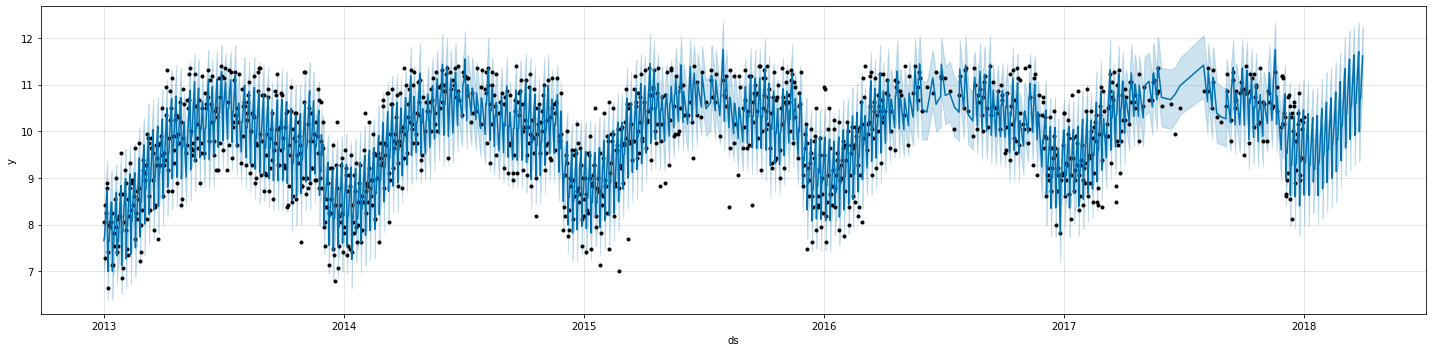

In [92]:
#The blue line in the graph represents the predicted values while the black dots represents the data in our dataset.
#and the light-blue shaded regions are the confidence intervals at 80%
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
fig = holiModel.plot(forecast_holi, ax=ax)
plt.show()

In [93]:
# Cross validation with model (seasonalities + holidays)
df_cv1 = cross_validation(holiModel , initial = '730 days', period = '45 days', horizon = '90 days')
df_performance1 = performance_metrics(df_cv1)
df_performance1.head()

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00


horizon       mse      rmse       mae      mape  coverage
0  9 days  0.274557  0.523982  0.403152  0.040821  0.794038
1 10 days  0.284620  0.533498  0.414095  0.042375  0.777236
2 11 days  0.281549  0.530612  0.412088  0.042338  0.781572
3 12 days  0.281023  0.530116  0.414698  0.042442  0.782364
4 13 days  0.280424  0.529551  0.414386  0.042480  0.770482

In [94]:
df_cv1.head()

ds      yhat  yhat_lower  yhat_upper          y     cutoff
0 2015-01-17  9.414352    8.742281   10.041014   9.273618 2015-01-16
1 2015-01-18  9.698322    9.104547   10.349713  10.488088 2015-01-16
2 2015-01-19  8.420155    7.757684    9.084905   7.937254 2015-01-16
3 2015-01-20  8.591700    7.958427    9.279299   8.185353 2015-01-16
4 2015-01-21  8.615743    7.965092    9.215808   8.774964 2015-01-16

In [95]:
print('-'*80)
print('\n RMSE for Prophet Model-seasonalities + holidays Forecast = '+str(np.mean(df_performance1.rmse)))  
print('-'*80, '\n\n')
print('-'*80)
print('\n MAPE for Prophet Model-seasonalities + holidays Forecast = '+str(np.mean(df_performance1.mape) * 100) + '%')
print('-'*80, '\n\n')


--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast = 0.521551356260695
-------------------------------------------------------------------------------- 


--------------------------------------------------------------------------------

 MAPE for Prophet Model-seasonalities + holidays Forecast = 4.124854000291511%
-------------------------------------------------------------------------------- 




****************************************
Store: 2 Item: 15 Predictions
****************************************


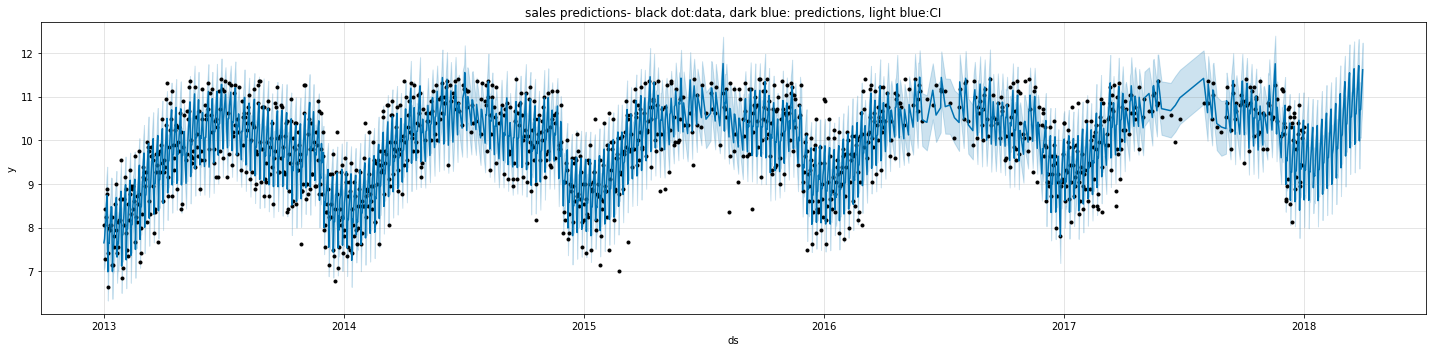

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.274557  0.523982  0.403152  0.040821  0.785908
1 10 days  0.284620  0.533498  0.414095  0.042375  0.769106
2 11 days  0.281549  0.530612  0.412088  0.042338  0.773442
3 12 days  0.281023  0.530116  0.414698  0.042442  0.766104
4 13 days  0.280424  0.529551  0.414386  0.042480  0.754221

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper          y     cutoff
0 2015-01-17  9.414352    8.768998   10.078187   9.273618 2015-01-16
1 2015-01-18  9.698322    9.058101   10.316977  10.488088 2015-01-16
2 2015-01-19  8.420155    7.817846    9.027089   7.937254 2015-01-16
3 2015-01-20  8.591700    8.024826    9.276912   8.185353 2015-01-16
4 2015-01-21  8.615743    7.992577    9.222789   8.774964 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 2 Item: 15 = 0.521551356260

In [96]:
train_model(2, 15)

#Prophet multiplicative
---------------------------
By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. 
However, in our dataset the time series has a clear yearly cycle, but the seasonality in the forecast is small at the start of the time series, increases gradually at the peak and small again at the end. In this time series, the seasonality is not a constant additive factor as assumed by Prophet, rather it showing slight growth and then shrikns again at the end. (with multiplicative seasonality, it keeps growing with the trend.) This might be the case of multiplicative seasonality. We will investigate this further and see if this change will bring any model improvement.

Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the input arguments

In [97]:
multiModel = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
multiModel.fit(df_store[['ds','y']]);

In [98]:
future_multi = multiModel.make_future_dataframe(periods=90)
future_multi.tail(n=3)

ds
1384 2018-03-29
1385 2018-03-30
1386 2018-03-31

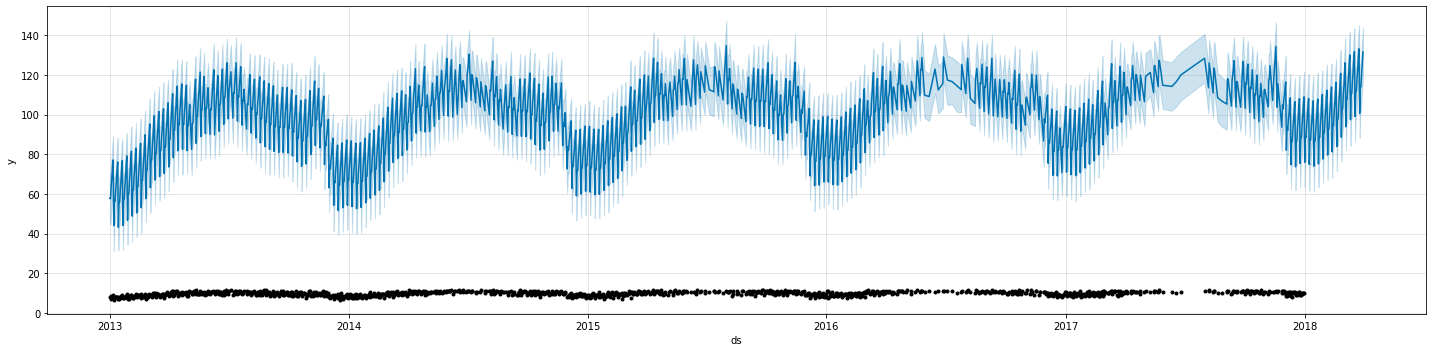

In [99]:
#The blue line in the graph represents the predicted values while the black dots represents the data in our dataset.
#and the light-blue shaded regions are the confidence intervals at 80%
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
fig = multiModel.plot(forecast, ax=ax)
plt.show()

In [100]:
# Cross validation with multiplicative model (seasonalities + holidays)
df_cv2 = cross_validation(multiModel , initial = '730 days', period = '45 days', horizon = '90 days')
df_performance2 = performance_metrics(df_cv2)
df_performance2.head()

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00


horizon       mse      rmse       mae      mape  coverage
0  9 days  0.272735  0.522241  0.405898  0.040987  0.785908
1 10 days  0.283561  0.532504  0.418171  0.042658  0.769106
2 11 days  0.282605  0.531606  0.419268  0.043000  0.773442
3 12 days  0.283837  0.532764  0.425433  0.043543  0.774234
4 13 days  0.283041  0.532016  0.423820  0.043445  0.762351

In [101]:
print('-'*60)
print('\n RMSE for Multiplicative Model Forecast = '+str(np.mean(df_performance2.rmse)))  
print('-'*60, '\n\n')
print('-'*60)
print('\n MAPE for Multiplicative Model Forecast = '+str(np.mean(df_performance2.mape) * 100) + '%')
print('-'*60, '\n')

------------------------------------------------------------

 RMSE for Multiplicative Model Forecast = 0.530929561794204
------------------------------------------------------------ 


------------------------------------------------------------

 MAPE for Multiplicative Model Forecast = 4.194725722687688%
------------------------------------------------------------ 



In [102]:
#It seems there is not much difference in additive Vs multiplicative models in terms of the performance improvements.
#We will choose the additive model with holidays to train rest of our models


ML Models - Rest of the time series
-----------------------------------------

****************************************
Store: 2 Item: 5 Predictions
****************************************


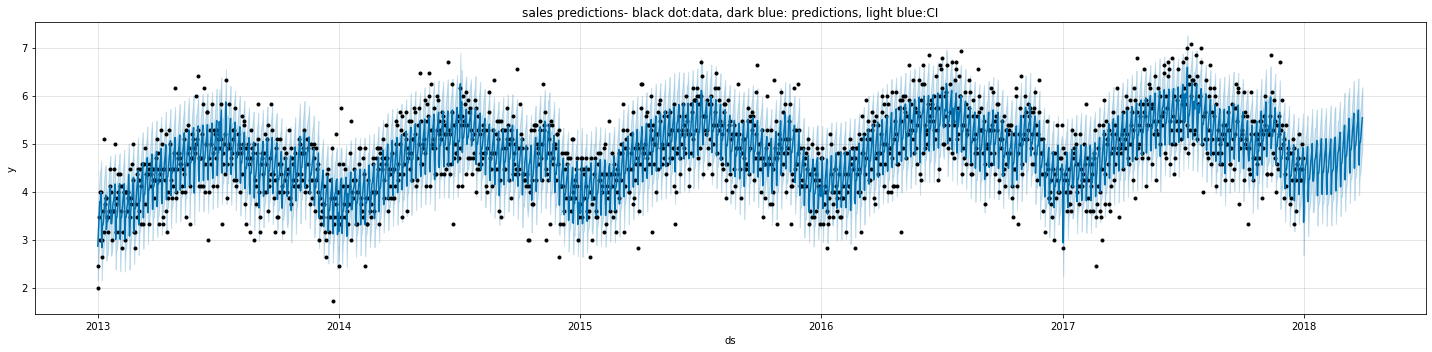

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.368844  0.607325  0.468535  0.104504  0.734300
1 10 days  0.311487  0.558110  0.434608  0.094312  0.753623
2 11 days  0.335119  0.578895  0.444062  0.097157  0.739130
3 12 days  0.327040  0.571874  0.441047  0.096166  0.753623
4 13 days  0.331995  0.576190  0.450927  0.097439  0.748792

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-01-17  4.705528    4.079869    5.309093  2.645751 2015-01-16
1 2015-01-18  4.952514    4.326173    5.594550  4.690416 2015-01-16
2 2015-01-19  3.999845    3.364590    4.645505  3.741657 2015-01-16
3 2015-01-20  4.056165    3.425958    4.633700  3.000000 2015-01-16
4 2015-01-21  4.058039    3.424870    4.651812  3.872983 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 2 Item: 5 = 0.5393638901940458
--

In [103]:
#store with highest sales and lowest item sales in the store
train_model(2, 5)

****************************************
Store: 5 Item: 15 Predictions
****************************************


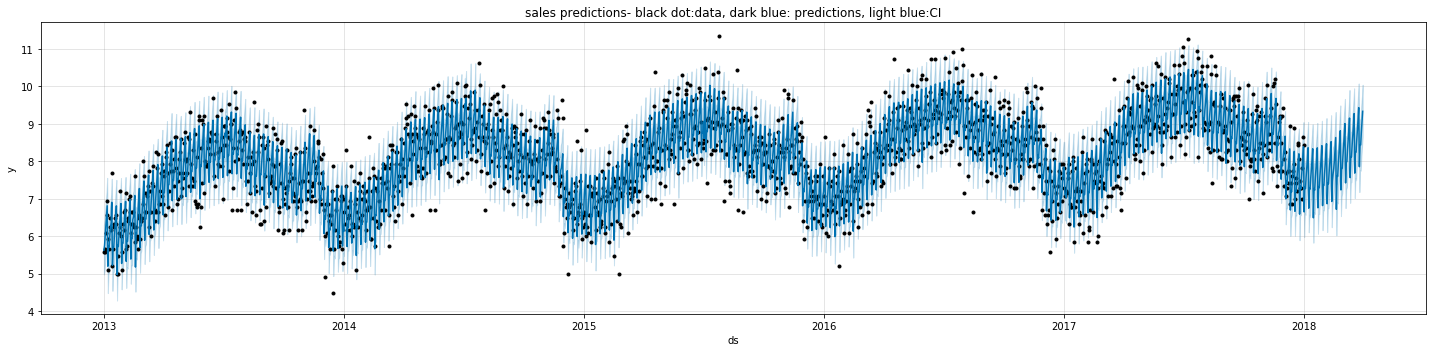

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.370800  0.608934  0.485494  0.058713  0.729469
1 10 days  0.366593  0.605469  0.483763  0.058306  0.743961
2 11 days  0.373158  0.610867  0.488372  0.058974  0.753623
3 12 days  0.343754  0.586305  0.471131  0.057122  0.768116
4 13 days  0.351081  0.592521  0.471048  0.057116  0.772947

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-01-17  7.580955    6.909691    8.260430  7.141428 2015-01-16
1 2015-01-18  7.914241    7.226912    8.609239  6.782330 2015-01-16
2 2015-01-19  5.740710    5.016495    6.422878  6.164414 2015-01-16
3 2015-01-20  6.919977    6.295192    7.604118  7.549834 2015-01-16
4 2015-01-21  6.744982    6.075726    7.466996  7.141428 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 5 Item: 15 = 0.5697225543140318
-

In [104]:
train_model(5, 15)

****************************************
Store: 5 Item: 5 Predictions
****************************************


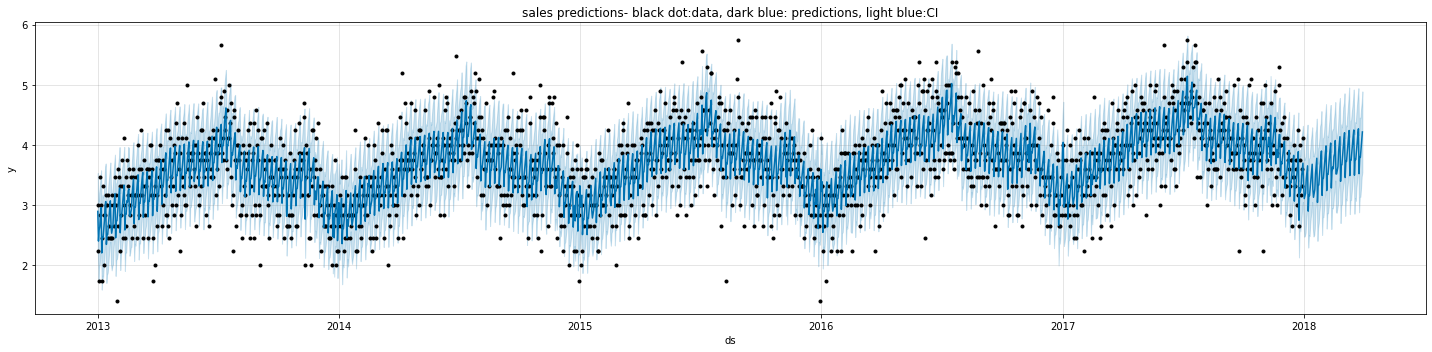

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.283728  0.532661  0.436693  0.119432  0.772947
1 10 days  0.289087  0.537668  0.437004  0.119909  0.758454
2 11 days  0.293977  0.542196  0.442413  0.121594  0.743961
3 12 days  0.285926  0.534721  0.432814  0.121462  0.743961
4 13 days  0.292875  0.541179  0.434145  0.122598  0.729469

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-01-17  3.486555    2.917836    4.131396  3.162278 2015-01-16
1 2015-01-18  3.588810    2.934611    4.246232  3.000000 2015-01-16
2 2015-01-19  2.879119    2.228754    3.575372  3.464102 2015-01-16
3 2015-01-20  2.937339    2.272310    3.604154  2.449490 2015-01-16
4 2015-01-21  3.016645    2.375699    3.669828  3.000000 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 5 Item: 5 = 0.5145799969508873
--

In [105]:
train_model(5, 5)

****************************************
Store: 7 Item: 15 Predictions
****************************************


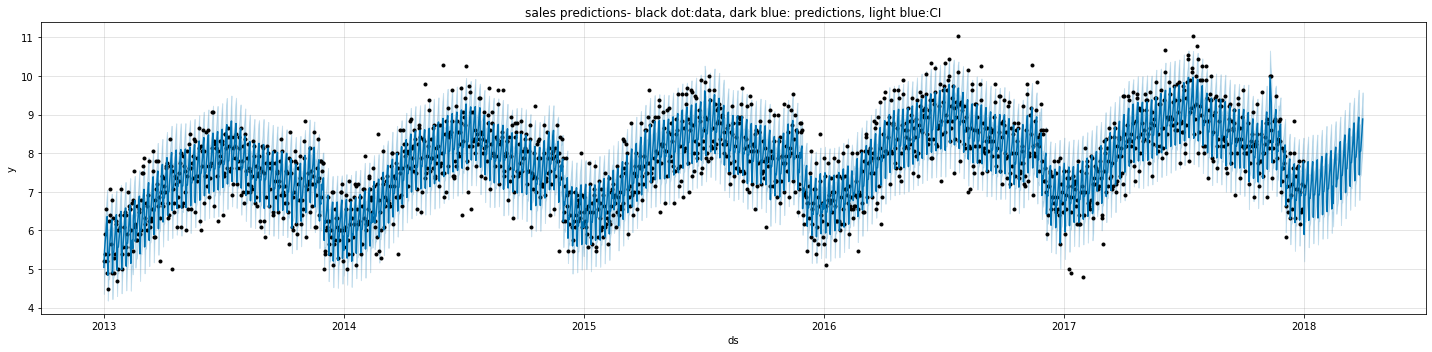

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.311625  0.558234  0.452309  0.057857  0.753623
1 10 days  0.327047  0.571880  0.457817  0.059150  0.748792
2 11 days  0.331716  0.575948  0.465810  0.060476  0.734300
3 12 days  0.334809  0.578627  0.466799  0.060704  0.719807
4 13 days  0.330035  0.574486  0.460357  0.059001  0.724638

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-01-17  7.208053    6.492959    7.863149  6.928203 2015-01-16
1 2015-01-18  7.337362    6.686528    7.986010  7.681146 2015-01-16
2 2015-01-19  5.546678    4.906167    6.273239  5.567764 2015-01-16
3 2015-01-20  6.519771    5.808293    7.168142  5.477226 2015-01-16
4 2015-01-21  6.517239    5.824296    7.198357  6.782330 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 7 Item: 15 = 0.5526187787936232
-

In [106]:
train_model(7, 15)

****************************************
Store: 7 Item: 5 Predictions
****************************************


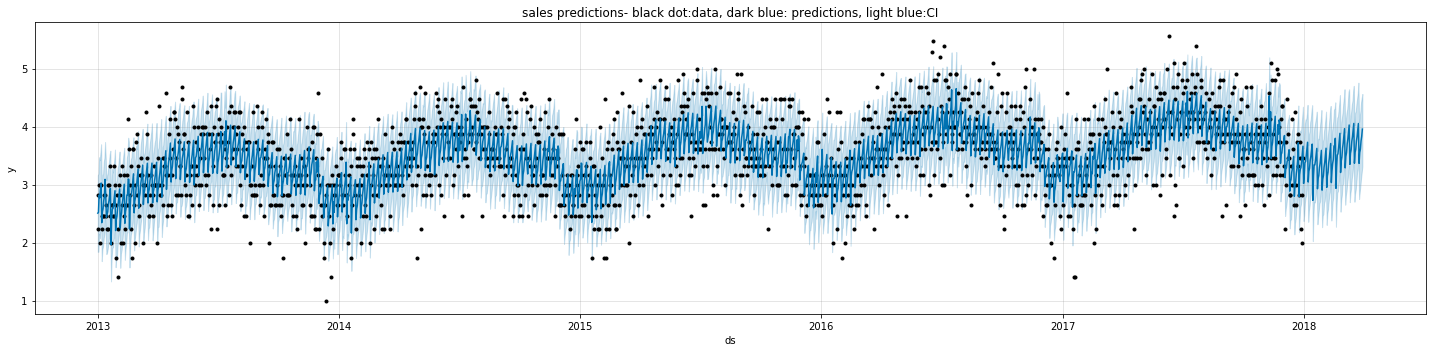

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.258791  0.508715  0.416277  0.120643  0.782609
1 10 days  0.263338  0.513165  0.421767  0.120117  0.792271
2 11 days  0.261856  0.511718  0.418869  0.119378  0.787440
3 12 days  0.249625  0.499624  0.405449  0.116940  0.797101
4 13 days  0.260372  0.510266  0.409004  0.121659  0.782609

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-01-17  3.486962    2.851977    4.065387  3.464102 2015-01-16
1 2015-01-18  3.505732    2.876912    4.108723  3.000000 2015-01-16
2 2015-01-19  2.179523    1.531589    2.798398  1.732051 2015-01-16
3 2015-01-20  3.134257    2.548844    3.785162  2.449490 2015-01-16
4 2015-01-21  3.213538    2.645267    3.839899  3.316625 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 7 Item: 5 = 0.5414532093049192
--

In [107]:
train_model(7, 5)

****************************************
Store: 8 Item: 15 Predictions
****************************************


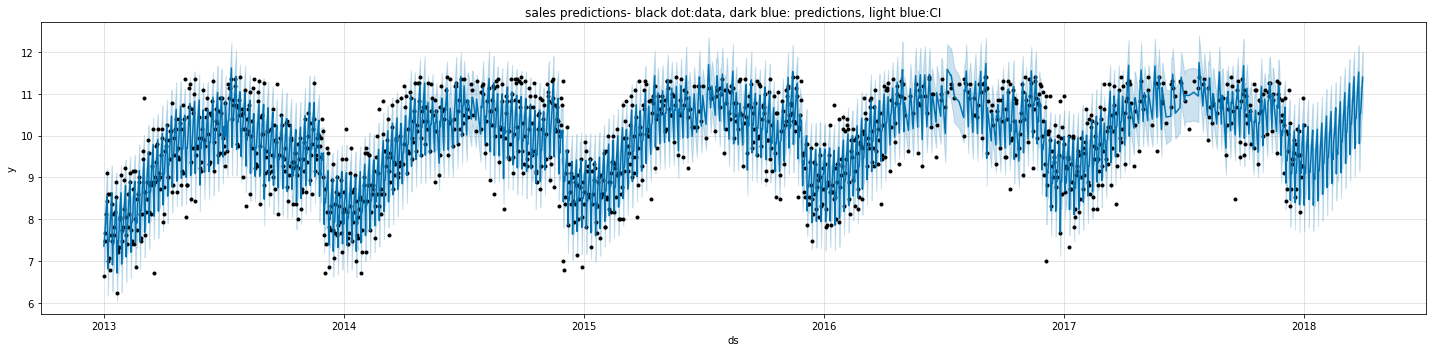

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.308413  0.555350  0.459316  0.046944  0.691021
1 10 days  0.309397  0.556235  0.458930  0.046740  0.679577
2 11 days  0.309208  0.556065  0.459404  0.046755  0.685998
3 12 days  0.309464  0.556295  0.462675  0.046939  0.685998
4 13 days  0.303495  0.550904  0.460686  0.046668  0.681027

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-01-17  9.436408    8.805400   10.033897  8.944272 2015-01-16
1 2015-01-18  9.637288    9.019455   10.267757  9.219544 2015-01-16
2 2015-01-19  7.463543    6.810651    8.094151  7.937254 2015-01-16
3 2015-01-20  8.402664    7.803036    9.012836  8.366600 2015-01-16
4 2015-01-21  8.292346    7.678249    8.936783  7.681146 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 8 Item: 15 = 0.5279781407175553
-

In [108]:
train_model(8, 15)

****************************************
Store: 8 Item: 5 Predictions
****************************************


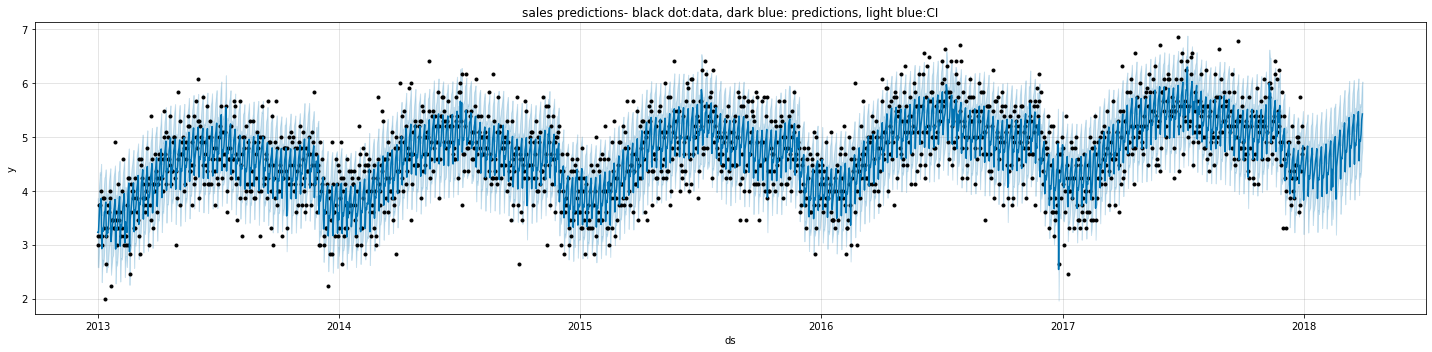

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-10-02 00:00:00



 Performance Metric sample:
  horizon       mse      rmse       mae      mape  coverage
0  9 days  0.278920  0.528129  0.428888  0.092591  0.758454
1 10 days  0.283350  0.532306  0.433560  0.093793  0.758454
2 11 days  0.304312  0.551645  0.453656  0.098248  0.724638
3 12 days  0.308517  0.555443  0.456772  0.098524  0.714976
4 13 days  0.298602  0.546445  0.440009  0.095225  0.734300

 Sample Predictions:
          ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2015-01-17  4.106539    3.482216    4.752371  3.316625 2015-01-16
1 2015-01-18  4.260949    3.640048    4.858040  4.472136 2015-01-16
2 2015-01-19  3.626131    3.026480    4.240541  3.316625 2015-01-16
3 2015-01-20  3.603033    2.993669    4.197365  3.741657 2015-01-16
4 2015-01-21  4.009441    3.418704    4.654979  4.358899 2015-01-16
--------------------------------------------------------------------------------

 RMSE for Prophet Model-seasonalities + holidays Forecast- Store: 8 Item: 5 = 0.515326248483036
---

In [109]:
train_model(8, 5)

Forecasting - 
===========
All of the 500 times series- 10 stores * 50 items

In [ ]:
#predicting next 90 days sales for all stores for all items

df_forecast = pd.DataFrame()
for s in range(1, 11):
    print('Predicting for store ' + str(s) + '...')
    for i in range(1, 51):
        df_storeitem = forecast_model(s, i)
        df_forecast = df_forecast.append(df_storeitem)
print('Finished')    

Predicting for store 1...


In [81]:
df_forecast.shape

(7650, 6)

In [82]:
df_forecast.head()

yhat  yhat_lower  yhat_upper         y  store  item
ds                                                                 
2013-01-01  3.092777    2.424051    3.706041  3.605551    1.0   1.0
2013-01-02  3.139651    2.497116    3.773826  3.316625    1.0   1.0
2013-01-03  3.110588    2.462952    3.825856  3.741657    1.0   1.0
2013-01-04  3.461745    2.828758    4.080127  3.605551    1.0   1.0
2013-01-05  3.582494    2.961339    4.225144  3.162278    1.0   1.0

In [ ]:
df_forecast.tail()

Comparison of Models
---------------------------

1. Baseline Model - Naive Approach
-----------------------------------

RMSE for Naive Forecast = 22.89943168817892

MAPE for Naive Forecast = 54.07746728841998 %


2. Prophet - Additive Model
---------------------------


RMSE for Additive Prophet Model Forecast = 10.114566932833608

MAPE for Additive Prophet Model Forecast = 8.133305871544037%


3. Prophet - Additive with seasonalities + holidays + special events and after removing the skew
-------------------------------------------------------------------------------------------------


RMSE for Prophet Model-seasonalities + holidays Forecast = 0.521551356260695

MAPE for Prophet Model-seasonalities + holidays Forecast = 4.124854000291511%


4. Prophet - Multiplicative with seasonalities + holidays + special events and after removing the skew
------------------------------------------------------------------------------------------------------


RMSE for Multiplicative Model Forecast = 0.530929561794204

MAPE for Multiplicative Model Forecast = 4.194725722687688%


Old Values - RMSE for Multiplicative Model Forecast = 22.766622115680192

Old Values - MAPE for Multiplicative Model Forecast = 52.025672014760836%


Future Improvements
=================

As we have seen earlier, our dataset had 500 timeseries for 10 stores with 50 items each. Right now we treated each time series seperately and trained/ forecasted the sales accordingly. 
However in future if fbProphet comes with any improvements of handling multiple time series together in one go, 
that will make the whole job of predicting in such scenarios a whole lot easier. And we will have to make changes accordingly too.